<a href="https://colab.research.google.com/github/co-min/ai_basic_study/blob/main/knn_dtw_trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe
!pip install dtw-python

  Using cached dtw_python-1.5.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (48 kB)
Using cached dtw_python-1.5.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (789 kB)


# TEST0
1. fastdtw, KNN 적용
2. 속도 최적화(FastDTW + 특징 벡터 캐싱 + 병렬 처리) + F1 Score 시각화 + Confusion Matrix + t-SNE 시각화
3. 아이디어


```
- FastDTW → DTW 계산 속도 대폭 향상
- 특징 벡터 캐싱 → 반복 영상 처리 시 다시 추출하지 않음
- 병렬 처리(멀티프로세싱) → 학습/테스트 영상 DTW 계산 병렬화
- F1 시각화 포함 → 클래스별 F1 Score, Confusion Matrix, t-SNE 시각화
```
4. 결과
```
4-1. 런타임
2분 소요

4-2. 실행 결과

```


In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567752 sha256=22e949b16e72e52dc9b24848026d173cf0f4825b79937622c3ae8b2d2b06a13e
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


# TEST 0 실험하기_ 웹캠과 최적화하기
1. KNN, fastdtw 적용
2. 아이디어

```
1. 프레임 샘플링 → 입력 프레임 수를 제한해 DTW 계산량 최소화
2. FastDTW 사용 → DTW 속도 향상
3. 멀티프로세싱 병렬 처리 → 학습 영상과 KNN 거리 계산 병렬화
4. 이동 평균 필터 적용 → 출력 라벨 흔들림 최소화
```
3. 결과


```
# 코드로 형식 지정됨
```

4. 보완


```
4-1. 주의
- smooth_window 값을 늘리면 라벨 흔들림은 더 줄지만 반응 속도는 늦어짐
- DTW 계산이 많으면 train_vectors 일부만 샘플링해 KNN 계산 속도 향상 가능


4-2. 개선 요약
1. num_frames=20 → 입력 프레임 샘플링으로 계산량 최소화
2. FastDTW + 병렬 처리 → 학습 영상과 KNN 거리 계산 속도 향상
3. 이동 평균 필터 (smooth_window=5) → 최근 5 프레임 예측 라벨을 기반으로 최종 라벨 결정, 흔들림 최소화
4. 실시간 출력 → 라벨, 평균 유사도, 판정 결과 표시

```




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
학습 영상: 15 테스트 영상: 4
영상: test/놀이터/KETI_SL_0000001005.avi | 실제: 놀이터 | 예측: 놀이터 | 유사도: 0.523
영상: test/놀이터/KETI_SL_0000000139.avi | 실제: 놀이터 | 예측: 놀이터 | 유사도: 0.592
영상: test/내일/KETI_SL_0000000168.avi | 실제: 내일 | 예측: 내일 | 유사도: 0.632
영상: test/내일/KETI_SL_0000001001.avi | 실제: 내일 | 예측: 내일 | 유사도: 0.597


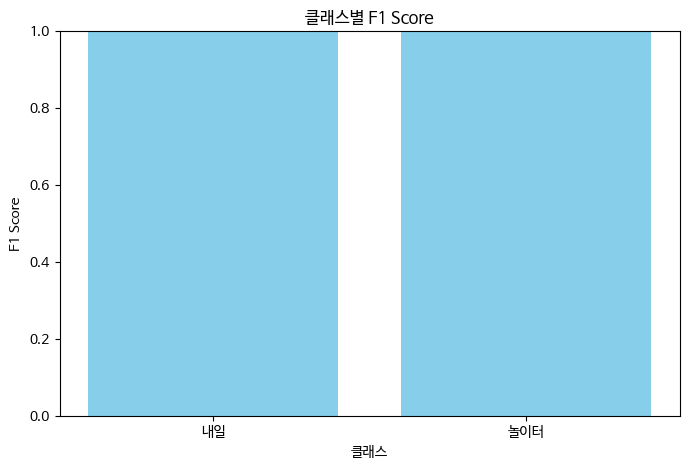

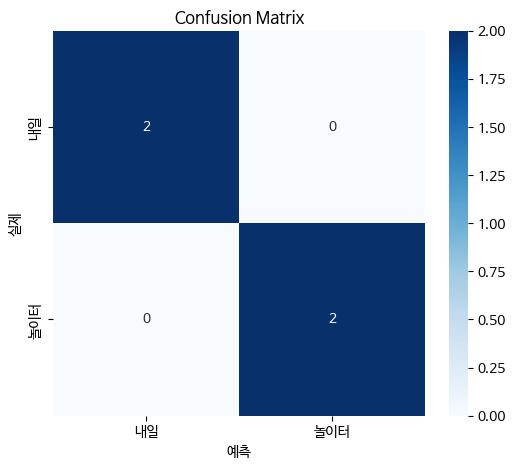

전체 F1 Score: 1.0


In [ ]:
import os
import pickle
from collections import Counter
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE


# Configure matplotlib to display Korean characters
!apt-get update -qq > /dev/null
!apt-get install fonts-nanum -qq > /dev/null
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False # Correctly display minus signs




# =====================================
# 1️⃣ DTW 계산 (FastDTW)
# =====================================
def compute_dtw(seq1, seq2):
    distance, _ = fastdtw(seq1, seq2, dist=euclidean)
    norm_dist = distance / (max(len(seq1), len(seq2)) * seq1.shape[1])
    return norm_dist

# =====================================
# 2️⃣ 가중합 DTW
# =====================================
def compute_weighted_dtw_from_vectors(arm1, hand1, torso1, arm2, hand2, torso2,
                                      w_arm=1.0, w_hand=1.1, w_torso=0.5):
    arm_dist = compute_dtw(arm1, arm2)
    hand_dist = compute_dtw(hand1, hand2)
    torso_dist = compute_dtw(torso1, torso2)
    total_dist = w_arm*arm_dist + w_hand*hand_dist + w_torso*torso_dist
    return total_dist, {"arm": arm_dist, "hand": hand_dist, "torso": torso_dist}

# =====================================
# 3️⃣ 비디오 특징 추출 및 캐싱
# =====================================
def extract_and_cache_vectors(video_list, num_frames=50, cache_file="video_vectors.pkl"):
    if os.path.exists(cache_file):
        with open(cache_file, "rb") as f:
            vectors = pickle.load(f)
        return vectors

    vectors = []
    for video_path, label in video_list:
        arm, hand, torso = extract_vector_groups(video_path)
        arm = resample_seq(arm, num_frames)
        hand = resample_seq(hand, num_frames)
        torso = resample_seq(torso, num_frames)
        vectors.append(((arm, hand, torso), label, video_path))
    with open(cache_file, "wb") as f:
        pickle.dump(vectors, f)
    return vectors

# =====================================
# 4️⃣ 병렬 KNN-DTW
# =====================================
def knn_dtw_classify_parallel(args):
    new_vecs, train_vectors, k, alpha, similarity_threshold = args
    new_arm, new_hand, new_torso = new_vecs
    results = []

    for train_vecs, label, _ in train_vectors:
        arm2, hand2, torso2 = train_vecs
        total_dist, parts = compute_weighted_dtw_from_vectors(new_arm, new_hand, new_torso,
                                                              arm2, hand2, torso2)
        similarity = np.exp(-alpha*total_dist)
        results.append({"label": label, "distance": total_dist, "similarity": similarity, "parts": parts})

    results.sort(key=lambda x: x["distance"])
    top_k = results[:k]
    top_labels = [r["label"] for r in top_k]
    predicted_label = Counter(top_labels).most_common(1)[0][0]
    avg_similarity = np.mean([r["similarity"] for r in top_k])
    judgment = "같은 동작" if avg_similarity >= similarity_threshold else "다른 동작"

    return predicted_label, avg_similarity, judgment, top_k

# =====================================
# 5️⃣ 학습/테스트 영상 리스트 생성
# =====================================
def make_video_list(root_dir):
    videos = []
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for file_name in os.listdir(class_path):
            if file_name.endswith(".avi"):
                videos.append((os.path.join(class_path, file_name), class_name))
    return videos

train_videos = make_video_list("train")
test_videos = make_video_list("test")
print("학습 영상:", len(train_videos), "테스트 영상:", len(test_videos))

# =====================================
# 6️⃣ 특징 벡터 캐싱
# =====================================
train_vectors = extract_and_cache_vectors(train_videos, num_frames=50, cache_file="train_vectors.pkl")
test_vectors = extract_and_cache_vectors(test_videos, num_frames=50, cache_file="test_vectors.pkl")

# =====================================
# 7️⃣ 병렬 KNN-DTW 예측
# =====================================
args_list = []
for (arm, hand, torso), label, video_path in test_vectors:
    args_list.append(((arm, hand, torso), train_vectors, 3, 6.5, 0.5))

with Pool(cpu_count()) as pool:
    results = pool.map(knn_dtw_classify_parallel, args_list)

y_true = [label for (_, label, _) in test_vectors]
y_pred = [res[0] for res in results]

# ---- 테스트 데이터셋 예측 결과 출력 ----
for i, (_, label, video_path) in enumerate(test_vectors):
    predicted_label, avg_similarity, judgment, top_k = results[i]
    print(f"영상: {video_path} | 실제: {label} | 예측: {predicted_label} | 유사도: {avg_similarity:.3f}")


# =====================================
# 8️⃣ F1 Score 및 Confusion Matrix
# =====================================
classes = sorted(list(set(y_true) | set(y_pred)))

# 클래스별 F1 Score
report = classification_report(y_true, y_pred, output_dict=True)
f1_scores = [report[c]['f1-score'] for c in classes]

plt.figure(figsize=(8,5))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylim(0,1)
plt.xlabel("클래스")
plt.ylabel("F1 Score")
plt.title("클래스별 F1 Score")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("예측")
plt.ylabel("실제")
plt.title("Confusion Matrix")
plt.show()

print("전체 F1 Score:", f1_score(y_true, y_pred, average='macro'))

# # =====================================
# # 9️⃣ t-SNE 시각화 (학습 데이터)
# # =====================================
# X, y_labels = [], []
# for (arm, hand, torso), label, _ in train_vectors:
#     vec = np.concatenate([arm.flatten(), hand.flatten(), torso.flatten()])
#     X.append(vec)
#     y_labels.append(label)

# X = np.array(X)
# n_samples = len(X)
# perplexity = min(30, n_samples - 1)  # TSNE의 요구 조건: perplexity < n_samples
# tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
# X_embedded = tsne.fit_transform(X)

# plt.figure(figsize=(8,6))
# for label in set(y_labels):
#     idx = [i for i, v in enumerate(y_labels) if v==label]
#     plt.scatter(X_embedded[idx,0], X_embedded[idx,1], label=label)
# plt.legend()
# plt.title("KNN-DTW 학습 데이터 t-SNE 시각화")
# plt.show()


# TEST 1
1. dtw 적용
2. KNN 미적용
3. 사용 단어: 놀이터
4. 결과:
```
DTW 거리: 70.31
유사도 점수: 0.245
판정 결과: 다른 동작
```

5. 개선해야할 문제


```
정규화 문제: 상대 좌표(벡터) 기반 특징으로 개선.
시간 문제: 리샘플링으로 프레임 수 맞추기.
잡음 문제: 손 좌표 안정화/스무딩.
스케일 문제: DTW 거리 프레임 수 기준으로 정규화.
```





In [ ]:
# import cv2
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from dtw import dtw
# import mediapipe as mp

# # --- MediaPipe Holistic 초기화 ---
# mp_holistic = mp.solutions.holistic
# holistic = mp_holistic.Holistic(static_image_mode=False,
#                                 model_complexity=1,
#                                 enable_segmentation=False,
#                                 refine_face_landmarks=False,
#                                 min_detection_confidence=0.5,
#                                 min_tracking_confidence=0.5)

# # --- 좌표 정규화 (상반신 기준) ---
# def normalize_upper_body_landmarks(landmarks):
#     if landmarks is None or len(landmarks) == 0:
#         return None
#     landmarks = np.array(landmarks)
#     left_shoulder, right_shoulder = landmarks[11], landmarks[12]
#     center = (left_shoulder + right_shoulder) / 2.0
#     landmarks -= center
#     shoulder_width = np.linalg.norm(left_shoulder - right_shoulder)
#     if shoulder_width > 1e-6:
#         landmarks /= shoulder_width
#     return landmarks

# # --- 영상 좌표 추출 + DataFrame + 보간 + NaN/inf 방지 ---
# def extract_upper_body_df(video_path):
#     cap = cv2.VideoCapture(video_path)
#     data = []
#     frame_idx = 0
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         result = holistic.process(frame_rgb)
#         landmarks_all = []

#         # 팔 좌표 (X,Y)
#         if result.pose_landmarks:
#             pose_lm = [[lm.x, lm.y] for lm in result.pose_landmarks.landmark]
#             pose_norm = normalize_upper_body_landmarks([lm+[0] for lm in pose_lm])
#             if pose_norm is not None:
#                 landmarks_all.extend(pose_norm[[11,12,13,14,15,16], :2].flatten().tolist())
#             else:
#                 landmarks_all.extend([0]*12)
#         else:
#             landmarks_all.extend([0]*12)

#         # 왼손 중심 좌표
#         if result.left_hand_landmarks:
#             left_hand = np.array([[lm.x,lm.y] for lm in result.left_hand_landmarks.landmark])
#             left_center = np.mean(left_hand, axis=0)
#         else:
#             left_center = np.array([0.0, 0.0])
#         landmarks_all.extend(left_center.tolist())

#         # 오른손 중심 좌표
#         if result.right_hand_landmarks:
#             right_hand = np.array([[lm.x,lm.y] for lm in result.right_hand_landmarks.landmark])
#             right_center = np.mean(right_hand, axis=0)
#         else:
#             right_center = np.array([0.0, 0.0])
#         landmarks_all.extend(right_center.tolist())

#         row = {'frame': frame_idx}
#         for idx, val in enumerate(landmarks_all):
#             row[f'landmark_{idx}'] = val
#         data.append(row)
#         frame_idx += 1
#     cap.release()
#     df = pd.DataFrame(data)

#     # --- 좌표 보간 + NaN/inf 제거 ---
#     coord_cols = df.columns[1:]
#     df[coord_cols] = df[coord_cols].replace([np.inf, -np.inf], np.nan)
#     df[coord_cols] = df[coord_cols].interpolate(method='linear', limit_direction='both')
#     df[coord_cols] = df[coord_cols].fillna(method='ffill').fillna(method='bfill')
#     df[coord_cols] = df[coord_cols].fillna(0.0)
#     return df

# # --- DTW 계산 (dtw 패키지) ---
# def compute_weighted_dtw_from_df(df1, df2, hand_weight=1.0):
#     arm1, arm2 = df1.iloc[:,1:13].to_numpy(), df2.iloc[:,1:13].to_numpy()
#     left1, left2 = df1.iloc[:,13:15].to_numpy(), df2.iloc[:,13:15].to_numpy()
#     right1, right2 = df1.iloc[:,15:17].to_numpy(), df2.iloc[:,15:17].to_numpy()

#     # dtw 패키지: euclidean distance
#     arm_dist = dtw(arm1, arm2).distance
#     left_dist = dtw(left1, left2).distance
#     right_dist = dtw(right1, right2).distance

#     return arm_dist + hand_weight*(left_dist + right_dist)

# # --- DTW → 유사도 변환 및 판정 ---
# def dtw_to_similarity(dtw_distance, alpha=0.02):
#     return np.exp(-alpha*dtw_distance)

# def judge_similarity(similarity_score, threshold=0.68):
#     return "같은 동작" if similarity_score >= threshold else "다른 동작"

# # --- 시각화 ---
# def plot_full_landmarks(df, title="Landmarks"):
#     frames = df['frame'].values
#     plt.figure(figsize=(12,5))
#     for i in range(0,12,2):
#         plt.plot(frames, df.iloc[:,1+i], label=f'Arm_{i//2}_x', linestyle='-')
#     plt.plot(frames, df.iloc[:,13], label='LeftHand_x', linestyle='--')
#     plt.plot(frames, df.iloc[:,15], label='RightHand_x', linestyle=':')
#     plt.title(title)
#     plt.xlabel("Frame")
#     plt.ylabel("Normalized X")
#     plt.legend()
#     plt.show()

# def compute_framewise_movement(df):
#     coords = df.iloc[:,1:].to_numpy()
#     diff = np.diff(coords, axis=0)
#     movement = np.linalg.norm(diff, axis=1)
#     movement = np.insert(movement, 0, 0)
#     return movement

# def plot_movement(df, title="Framewise Movement"):
#     movement = compute_framewise_movement(df)
#     plt.figure(figsize=(12,4))
#     plt.plot(df['frame'], movement, color='red')
#     plt.title(title)
#     plt.xlabel("Frame")
#     plt.ylabel("Movement magnitude")
#     plt.show()

# # --- 종합 비교 ---
# video1 = "/content/KETI_SL_0000000139.avi"
# video2 = "/content/KETI_SL_0000001005.avi"

# df1 = extract_upper_body_df(video1)
# df2 = extract_upper_body_df(video2)

# # 시각화
# plot_full_landmarks(df1, "Video1 팔+손 좌표")
# plot_full_landmarks(df2, "Video2 팔+손 좌표")
# plot_movement(df1, "Video1 팔+손 움직임 합계")
# plot_movement(df2, "Video2 팔+손 움직임 합계")

# # DTW 계산 및 유사도
# dtw_distance = compute_weighted_dtw_from_df(df1, df2)
# similarity_score = dtw_to_similarity(dtw_distance)
# result = judge_similarity(similarity_score)

# print(f"DTW 거리: {dtw_distance:.2f}")
# print(f"유사도 점수: {similarity_score:.3f}")
# print(f"판정 결과: {result}")

# TEST 2
1. dtw 적용
2. KNN 미적용
3. 사용 단어: 놀이터
4. 결과


```
정규화된 DTW 거리: 0.4620
유사도 점수: 0.397
판정 결과: 다른 동작
```
5. 보완할 사안



```
특징 확장(상체 주요 관절 상대 벡터 추가).
거리 정규화 개선(DTW 거리를 프레임 수 × 차원 수로 나누기).
alpha와 threshold를 튜닝 파라마터.
```




In [ ]:
# import cv2
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from dtw import dtw
# import mediapipe as mp

# # --- MediaPipe Holistic 초기화 ---
# mp_holistic = mp.solutions.holistic
# holistic = mp_holistic.Holistic(static_image_mode=False,
#                                 model_complexity=1,
#                                 enable_segmentation=False,
#                                 refine_face_landmarks=False,
#                                 min_detection_confidence=0.5,
#                                 min_tracking_confidence=0.5)

# # --- 상대 벡터 특징 추출 ---
# def extract_relative_vectors(pose_landmarks):
#     if pose_landmarks is None:
#         return None
#     lm = np.array([[l.x, l.y] for l in pose_landmarks.landmark])

#     # 주요 관절 쌍 (왼쪽/오른쪽 어깨-팔꿈치, 팔꿈치-손목)
#     pairs = [(11,13), (13,15), (12,14), (14,16)]
#     vectors = []
#     for a,b in pairs:
#         v = lm[b] - lm[a]
#         norm = np.linalg.norm(v) + 1e-6
#         vectors.extend((v / norm).tolist())  # 단위 벡터

#     # 손목 좌표 (튀지 않게 기본만 사용)
#     vectors.extend(lm[15].tolist())  # left wrist
#     vectors.extend(lm[16].tolist())  # right wrist

#     return vectors

# # --- 비디오 처리 ---
# def extract_vector_df(video_path):
#     cap = cv2.VideoCapture(video_path)
#     data = []
#     frame_idx = 0
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         result = holistic.process(frame_rgb)

#         if result.pose_landmarks:
#             features = extract_relative_vectors(result.pose_landmarks)
#         else:
#             features = [0.0]*12  # 기본 길이 맞추기
#         row = {'frame': frame_idx}
#         for idx, val in enumerate(features):
#             row[f'feat_{idx}'] = val
#         data.append(row)
#         frame_idx += 1
#     cap.release()
#     return pd.DataFrame(data)

# # --- 리샘플링 ---
# def resample_df(df, num_frames=100):
#     coords = df.iloc[:,1:].to_numpy()
#     new_idx = np.linspace(0, len(coords)-1, num_frames)
#     resampled = np.array([
#         np.interp(new_idx, np.arange(len(coords)), coords[:,i])
#         for i in range(coords.shape[1])
#     ]).T
#     return resampled

# # --- DTW 계산 ---
# def compute_dtw(seq1, seq2):
#     dist = dtw(seq1, seq2).distance
#     norm_dist = dist / max(len(seq1), len(seq2))  # 프레임 수 정규화
#     return norm_dist

# # --- 유사도 변환 ---
# def dtw_to_similarity(dtw_distance, alpha=2.0):  # alpha를 크게 줘도 됨
#     return np.exp(-alpha*dtw_distance)

# def judge_similarity(similarity_score, threshold=0.68):
#     return "같은 동작" if similarity_score >= threshold else "다른 동작"

# # --- 실행 ---
# video1 = "/content/KETI_SL_0000000139.avi"
# video2 = "/content/KETI_SL_0000001005.avi"

# df1 = extract_vector_df(video1)
# df2 = extract_vector_df(video2)

# seq1 = resample_df(df1, num_frames=100)
# seq2 = resample_df(df2, num_frames=100)

# dtw_distance = compute_dtw(seq1, seq2)
# similarity_score = dtw_to_similarity(dtw_distance)
# result = judge_similarity(similarity_score)

# print(f"정규화된 DTW 거리: {dtw_distance:.4f}")
# print(f"유사도 점수: {similarity_score:.3f}")
# print(f"판정 결과: {result}")


# TEST 3
1. dtw 적용
2. KNN 미적용
3. 사용 단어: 놀이터
4. 결과


```
정규화된 DTW 거리: 0.0297
유사도 점수: 0.862
판정 결과: 같은 동작
```
5. 보완할 사안



```
KNN으로 분류하는 작업하기

다른 동작인데(놀이터, 내일) 결과가 같은 동작이라고 판단함.

정규화된 DTW 거리: 0.0450
유사도 점수: 0.798
판정 결과: 같은 동작

-> 판별력 부족

```




In [ ]:
# import cv2
# import numpy as np
# import pandas as pd
# from dtw import dtw
# import mediapipe as mp

# # --- MediaPipe Holistic 초기화 ---
# mp_holistic = mp.solutions.holistic
# holistic = mp_holistic.Holistic(static_image_mode=False,
#                                 model_complexity=1,
#                                 enable_segmentation=False,
#                                 refine_face_landmarks=False,
#                                 min_detection_confidence=0.5,
#                                 min_tracking_confidence=0.5)

# # --- 상대 벡터 특징 추출 ---
# def extract_relative_vectors(pose_landmarks):
#     if pose_landmarks is None:
#         return None
#     lm = np.array([[l.x, l.y] for l in pose_landmarks.landmark])

#     vectors = []

#     # 팔 벡터 (왼/오)
#     pairs = [(11,13), (13,15), (12,14), (14,16)]
#     for a,b in pairs:
#         v = lm[b] - lm[a]
#         norm = np.linalg.norm(v) + 1e-6
#         vectors.extend((v / norm).tolist())

#     # 상체 중심 벡터 (코-어깨 중심, 어깨-허리 중심)
#     center_shoulder = (lm[11] + lm[12]) / 2
#     center_hip = (lm[23] + lm[24]) / 2
#     v1 = lm[0] - center_shoulder  # 코 - 어깨중심
#     v2 = center_shoulder - center_hip  # 어깨중심 - 허리중심
#     for v in [v1, v2]:
#         norm = np.linalg.norm(v) + 1e-6
#         vectors.extend((v / norm).tolist())

#     # 손목 좌표
#     vectors.extend(lm[15].tolist())
#     vectors.extend(lm[16].tolist())

#     return vectors

# # --- 비디오 처리 ---
# def extract_vector_df(video_path):
#     cap = cv2.VideoCapture(video_path)
#     data = []
#     frame_idx = 0
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         result = holistic.process(frame_rgb)

#         if result.pose_landmarks:
#             features = extract_relative_vectors(result.pose_landmarks)
#         else:
#             features = [0.0]*16  # 특징 차원 맞추기
#         row = {'frame': frame_idx}
#         for idx, val in enumerate(features):
#             row[f'feat_{idx}'] = val
#         data.append(row)
#         frame_idx += 1
#     cap.release()
#     return pd.DataFrame(data)

# # --- 리샘플링 ---
# def resample_df(df, num_frames=100):
#     coords = df.iloc[:,1:].to_numpy()
#     new_idx = np.linspace(0, len(coords)-1, num_frames)
#     resampled = np.array([
#         np.interp(new_idx, np.arange(len(coords)), coords[:,i])
#         for i in range(coords.shape[1])
#     ]).T
#     return resampled

# # --- DTW 계산 ---
# def compute_dtw(seq1, seq2):
#     dist = dtw(seq1, seq2).distance
#     norm_dist = dist / (max(len(seq1), len(seq2)) * seq1.shape[1])  # 프레임 × 차원 수
#     return norm_dist

# # --- 유사도 변환 ---
# def dtw_to_similarity(dtw_distance, alpha=7.0):
#     return np.exp(-alpha*dtw_distance)

# def judge_similarity(similarity_score, threshold=0.5):
#     return "같은 동작" if similarity_score >= threshold else "다른 동작"

# # --- 실행 ---
# video1 = "/content/놀이터/KETI_SL_0000000139.avi"
# video2 = "/content/놀이터/KETI_SL_0000001005.avi"
# video3 = "/content/내일/KETI_SL_0000000168.avi"
# video4 = "/content/내일/KETI_SL_0000001001.avi"

# df1 = extract_vector_df(video3)
# df2 = extract_vector_df(video2)

# seq1 = resample_df(df1, num_frames=100)
# seq2 = resample_df(df2, num_frames=100)

# dtw_distance = compute_dtw(seq1, seq2)
# similarity_score = dtw_to_similarity(dtw_distance, alpha=5.0)
# result = judge_similarity(similarity_score, threshold=0.5)

# print(f"정규화된 DTW 거리: {dtw_distance:.4f}")
# print(f"유사도 점수: {similarity_score:.3f}")
# print(f"판정 결과: {result}")


IndexError: index 0 is out of bounds for axis 0 with size 0

# TEST 3_다른 단어 실험

사용 단어: 내일 2개 영상

```
정규화된 DTW 거리: 0.0198
유사도 점수: 0.906
판정 결과: 같은 동작
```

사용 단어: 내일3 vs 놀이터2



```
정규화된 DTW 거리: 0.0450
유사도 점수: 0.798
판정 결과: 같은 동작
```

-> 판별력 부족. 과도한 정규화



# TEST 3의 판별력 부족 현상



```
1. 특징 벡터가 과도하게 정규화됨

모든 벡터를 단위 벡터화했기 때문에, 동작의 크기/세기가 거의 반영되지 않음.
즉, "팔을 크게 휘두르는 동작"과 "작게 움직이는 동작"이 유사하게 나옴.

2. 손 좌표/상체 특징이 단순

손 모양, 손 움직임 같은 차이를 반영하지 못하고 있음.
그래서 "다른 단어 동작"인데도, 상체/팔 움직임이 비슷하면 "같은 동작"으로 인식.

3. 단일 임계치(threshold) 사용

DTW 기반에서는 같은 동작과 다른 동작 간의 거리가 연속적 분포임.
따라서 고정 threshold로는 안정적인 분류가 어려움.
```


보완방법



```
1. 특징 벡터 확장 (길이+방향 모두 포함)
2. 팔 / 손 / 상체 별 DTW 분리 → 가중합
3. threshold를 데이터셋 기반으로 튜닝 (고정값 대신 경험적/통계적 기준)
```




# TEST 4
1. dtw 적용, KNN 미적용
2. 팔 / 손 / 상체 각각 따로 DTW → 가중합 방식
3. 사용 단어: 놀이터
4. 아이디어


```
1. 팔 특징
- 어깨-팔꿈치, 팔꿈치-손목 벡터 (길이+방향 포함)

2. 손 특징
- 손목 좌표 + 손 중심점 좌표

3. 상체 특징
- 코–어깨 중심, 어깨–허리 중심 벡터 (길이+방향 포함)

4. 각 그룹별 DTW
- 팔 거리, 손 거리, 상체 거리 따로 계산
- 최종 거리 = 팔*가중치 + 손*가중치 + 상체*가중치

5. 정규화
- (거리 / (프레임수 × 차원수)) 방식 유지
```


5. 결과


```
부위별 거리: {'arm': 0.022039711976678745, 'hand': 0.05005793077203306, 'torso': 0.010394397115315502}
총합 정규화된 DTW 거리: 0.1023
유사도 점수: 0.359
판정 결과: 다른 동작
```


6. 보완할 사안



```
1. 손 가중치 줄이기
w_hand를 1.5 → 0.5 이하로 줄이면, 손 때문에 과도하게 불일치하는 문제를 완화할 수 있음.

2. alpha 값 줄이기
alpha=10은 작은 차이에도 유사도를 급격히 낮춤.
alpha=3~5 정도로 하면 같은 동작은 "같다"로 잡힐 가능성이 큼.

3. 손 좌표 안정화
손 중심점 대신 손목 좌표만 쓰거나,
이동 평균/저역 통과 필터(Savitzky-Golay filter)로 손 좌표를 매끄럽게 처리.
```



In [ ]:
video1 = "/content/놀이터/KETI_SL_0000001754.avi"
video2 = "/content/놀이터/KETI_SL_0000002653.avi"
video3 = "/content/내일/KETI_SL_0000001750.avi"
video4 = "/content/내일/KETI_SL_0000002682.avi"

In [ ]:
import cv2
import numpy as np
import pandas as pd
# from scipy.interpolate import interp1d
from dtw import dtw
import mediapipe as mp

# --- MediaPipe 초기화 ---
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(static_image_mode=False,
                                model_complexity=1,
                                enable_segmentation=False,
                                refine_face_landmarks=False,
                                min_detection_confidence=0.5,
                                min_tracking_confidence=0.5)

# --- 특징 추출 (팔, 손, 상체 구분) ---
def extract_group_features(pose_landmarks, left_hand=None, right_hand=None):
    if pose_landmarks is None:
        return None, None, None

    lm = np.array([[l.x, l.y] for l in pose_landmarks.landmark])

    # 1) 팔 특징
    arm_pairs = [(11,13), (13,15), (12,14), (14,16)]
    arm_feats = []
    for a,b in arm_pairs:
        v = lm[b] - lm[a]
        arm_feats.extend(v.tolist())                       # 길이 포함
        norm = np.linalg.norm(v) + 1e-6
        arm_feats.extend((v/norm).tolist())                # 방향 포함

    # 2) 상체 특징
    center_shoulder = (lm[11] + lm[12]) / 2
    center_hip = (lm[23] + lm[24]) / 2
    torso_pairs = [(0, center_shoulder), (center_shoulder, center_hip)]
    torso_feats = []
    for a,b in torso_pairs:
        v = (a - b) if isinstance(a, np.ndarray) else (lm[a] - b)
        torso_feats.extend(v.tolist())
        norm = np.linalg.norm(v) + 1e-6
        torso_feats.extend((v/norm).tolist())

    # 3) 손 특징
    hand_feats = []
    # 손목 좌표
    hand_feats.extend(lm[15].tolist())  # left wrist
    hand_feats.extend(lm[16].tolist())  # right wrist
    # 손 중심점
    if left_hand:
        left_center = np.mean([[l.x,l.y] for l in left_hand.landmark], axis=0)
    else:
        left_center = np.array([0.0,0.0])
    if right_hand:
        right_center = np.mean([[l.x,l.y] for l in right_hand.landmark], axis=0)
    else:
        right_center = np.array([0.0,0.0])
    hand_feats.extend(left_center.tolist())
    hand_feats.extend(right_center.tolist())

    return np.array(arm_feats), np.array(hand_feats), np.array(torso_feats)

# --- 비디오 벡터 추출 처리 ---
def extract_vector_groups(video_path):
    cap = cv2.VideoCapture(video_path)
    arm_list, hand_list, torso_list = [], [], []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = holistic.process(frame_rgb)

        if result.pose_landmarks:
            arm, hand, torso = extract_group_features(
                result.pose_landmarks,
                result.left_hand_landmarks,
                result.right_hand_landmarks
            )
            arm_list.append(arm)
            hand_list.append(hand)
            torso_list.append(torso)
    cap.release()
    return np.array(arm_list), np.array(hand_list), np.array(torso_list)

# --- 리샘플링 시도1 ---
def resample_seq(seq, num_frames=100):
    # seq = np.array(seq)  # 리스트도 배열로 변환
    # if seq.size == 0:  # 빈 배열이면
    #     return np.zeros((num_frames, 1))  # 또는 feature 수에 맞게 조정
    # if seq.ndim == 1:
    #     seq = seq[:, np.newaxis]  # (N,) -> (N,1)
    new_idx = np.linspace(0, len(seq)-1, num_frames)
    resampled = np.array([
        np.interp(new_idx, np.arange(len(seq)), seq[:,i])
        for i in range(seq.shape[1])
    ]).T
    return resampled

# # 리샘플링 조정 Adaptive
# def adaptive_num_frames(seq1, seq2, max_frames=150):
#     N1, N2 = len(seq1), len(seq2)
#     return min(max(N1, N2), max_frames)

# def resample_seq(seq, num_frames=100):
#     seq = np.array(seq)
#     if seq.size == 0:
#         return np.zeros((num_frames, 1))
#     if seq.ndim == 1:
#         seq = seq[:, np.newaxis]
#     new_idx = np.linspace(0, len(seq)-1, num_frames)
#     resampled = np.zeros((num_frames, seq.shape[1]))
#     for i in range(seq.shape[1]):
#         f = interp1d(np.arange(len(seq)), seq[:,i], kind='cubic', fill_value="extrapolate")
#         resampled[:,i] = f(new_idx)
#     return resampled




# --- DTW 거리 계산 ---
def compute_dtw(seq1, seq2):
    dist = dtw(seq1, seq2).distance
    norm_dist = dist / (max(len(seq1), len(seq2)) * seq1.shape[1])
    return norm_dist



# --- 가중합 DTW ---

# w_hand = 1.5 -> 0.5 수정 -> 1.0 수정
def compute_weighted_dtw(video1, video2, num_frames=100,
                         w_arm=1.0, w_hand=1.0, w_torso=0.5):
    arm1, hand1, torso1 = extract_vector_groups(video1)
    arm2, hand2, torso2 = extract_vector_groups(video2)

    arm1, arm2 = resample_seq(arm1, num_frames), resample_seq(arm2, num_frames)
    hand1, hand2 = resample_seq(hand1, num_frames), resample_seq(hand2, num_frames)
    torso1, torso2 = resample_seq(torso1, num_frames), resample_seq(torso2, num_frames)

    arm_dist = compute_dtw(arm1, arm2)
    hand_dist = compute_dtw(hand1, hand2)
    torso_dist = compute_dtw(torso1, torso2)

    total_dist = w_arm*arm_dist + w_hand*hand_dist + w_torso*torso_dist
    return total_dist, {"arm": arm_dist, "hand": hand_dist, "torso": torso_dist}

# --- 유사도 변환 ---

# alpha=10.0 -> 4.0 -> 6.0 -> 7.0
def dtw_to_similarity(dtw_distance, alpha=6.5):
    return np.exp(-alpha*dtw_distance)

def judge_similarity(similarity_score, threshold=0.5):
    return "같은 동작" if similarity_score >= threshold else "다른 동작"

# --- 실행 ---

dtw_distance, parts = compute_weighted_dtw(video3, video2, num_frames=100)

# alpha=10.0 -> 4.0 -> 6.0 -> 7.0
similarity_score = dtw_to_similarity(dtw_distance, alpha=6.5)
result = judge_similarity(similarity_score, threshold=0.5)

print("부위별 거리:", parts)
print(f"총합 정규화된 DTW 거리: {dtw_distance:.4f}")
print(f"유사도 점수: {similarity_score:.3f}")
print(f"판정 결과: {result}")


부위별 거리: {'arm': 0.06165418192649796, 'hand': 0.10667171793073224, 'torso': 0.020085561683611884}
총합 정규화된 DTW 거리: 0.1784
유사도 점수: 0.314
판정 결과: 다른 동작


# TEST 4 실험하기

1. 튜닝해보기



```
dtw_distance, parts = compute_weighted_dtw(video1, video2,
                                           num_frames=100,
                                           w_arm=1.0, w_hand=0.5, w_torso=0.5)
similarity_score = dtw_to_similarity(dtw_distance, alpha=4.0)
result = judge_similarity(similarity_score, threshold=0.5)

```

1-1. 튜닝 결과: '놀이터' 단어 영상 1, 2 비교


```
부위별 거리: {'arm': 0.022039711976678745, 'hand': 0.05005793077203306, 'torso': 0.010394397115315502}
총합 정규화된 DTW 거리: 0.0523
유사도 점수: 0.811
판정 결과: 같은 동작
```


2. 다른 단어로 비교해보기

놀이터 영상2 vs 내일 영상3 비교

```
1. w_hand=0.5 -> 1.0, alpha = 4.0

0.5=>
총합 정규화된 DTW 거리: 0.0754
유사도 점수: 0.740
판정 결과: 같은 동작

1.0 =>  
총합 정규화된 DTW 거리: 0.1036
유사도 점수: 0.661
판정 결과: 같은 동작


2. alpha = 4.0 -> 6.0, w_hand = 1.0

6.0 =>
총합 정규화된 DTW 거리: 0.1036
유사도 점수: 0.537
판정 결과: 같은 동작


3. alpha = 7.0, w_hand = 1.1

총합 정규화된 DTW 거리: 0.1092
유사도 점수: 0.466
판정 결과: 다른 동작


```


3. alpha = 7.0, w_hand = 1.1



```
3-1. '놀이터' 같은 동작 영상 1, 2 비교

총합 정규화된 DTW 거리: 0.0823
유사도 점수: 0.562
판정 결과: 같은 동작


3-2. '내일' 같은 동작 영상 3, 4 비교

총합 정규화된 DTW 거리: 0.0579
유사도 점수: 0.667
판정 결과: 같은 동작

3-3. '내일' vs '놀이터' 다른 동작 1, 4 비교

총합 정규화된 DTW 거리: 0.1321
유사도 점수: 0.397
판정 결과: 다른 동작

```

4. alpha = 6.5, w_hand = 1.0

```
4-1. 같은 동작 영상 1, 2
부위별 거리: {'arm': 0.02606438510760586, 'hand': 0.07353348167204508, 'torso': 0.013739039883695655}
총합 정규화된 DTW 거리: 0.1065
유사도 점수: 0.501
판정 결과: 같은 동작



4-2. 다른 동작 영상 2, 3
부위별 거리: {'arm': 0.06165418192649796, 'hand': 0.10667171793073224, 'torso': 0.020085561683611884}
총합 정규화된 DTW 거리: 0.1784
유사도 점수: 0.314
판정 결과: 다른 동작
```




5. 보완해야 하는 점



```
데이터셋 확장을 대비한다면:

1. Grid Search로 여러 하이퍼파라미터 탐색(여러 영상 쌍 돌려서 최적 alpha, weight, threshold 찾는 코드)

2. 같은/다른 동작 거리 분포 분석 → threshold를 통계적으로 결정

3. 손 좌표 스무딩으로 튀는 값 억제
```








# TEST 4의 확장 KNN으로 단어 분류하기
1. dtw 적용, KNN 적용
2. 팔 / 손 / 상체 각각 따로 DTW → 가중합 방식
3. 사용 단어: 놀이터
4. 아이디어


```
1. 부위별 가중치 반영 → 팔, 손, 상체 거리별로 서로 다른 중요도 적용 가능

2. 유사도 점수 계산 → exp(-alpha * total_distance)로 0~1 정규화

3. KNN 다수결 → 상위 k개 가까운 샘플로 최종 단어 예측

4. 판정 결과 → 유사도 평균 기준으로 "같은 동작 / 다른 동작" 판정
```


5. 결과


```
예측된 단어: 놀이터
상위 k개 평균 유사도: 0.5092590314288655
판정 결과: 같은 동작
상위 k개 상세:
  레이블: 놀이터, 거리: 0.0813, 부위별 거리: {'arm': 0.02874842831562198, 'hand': 0.041718260554771396, 'torso': 0.01323323324153275}, 유사도: 0.566
  레이블: 놀이터, 거리: 0.0898, 부위별 거리: {'arm': 0.022944634695613798, 'hand': 0.05741336899176095, 'torso': 0.007420204227415066}, 유사도: 0.533
  레이블: 내일, 거리: 0.1211, 부위별 거리: {'arm': 0.03798392865688083, 'hand': 0.0725872075844405, 'torso': 0.006631785114753149}, 유사도: 0.428
```


6. 보완할 사안



```
1. 실제 실시간 영상 입력에서 바로 KNN 판정까지 연결 필요
2. 정밀도 평가 f1-score 필요.


3. 테스트 데이터셋이 충분히 다양해야 KNN 모델 성능 평가가 신뢰됨.
4. 부위별 가중치(w_arm, w_hand, w_torso)나 alpha, num_frames, k 값을 그리드 서치로 튜닝하면 성능 향상 가능.


```



# DTW+KNN로 새 단어 예측하기
1. dtw, knn 적용
2. w_hand = 1.0, alpha = 6.5
3. 아이디어


```
1.train_videos는 KNN 기준 샘플, new_videos는 테스트할 새 영상
2. 각 영상마다 예측 라벨, 평균 유사도, 판정, 상위 K개 세부 결과 출력
3.KNN-DTW 예측 수행 후 y_true / y_pred 채움
4.클래스별 F1 Score 막대그래프 → 클래스별 성능 확인
5. Confusion Matrix Heatmap → 어떤 클래스가 혼동되는지 확인
6. t-SNE 시각화 → 학습 데이터 특징 벡터 기반 군집 확인
7. 전체 F1 Score 출력
```

런타임: 6분 이상


4. 결과


```
# 코드로 형식 지정됨
```


5. 보완

In [ ]:
from collections import Counter
import numpy as np

# --- KNN 분류기 (부위별 DTW + 유사도 점수 포함) ---
def knn_dtw_classify(new_video, train_videos, k=3,
                     num_frames=100, w_arm=1.0, w_hand=1.1, w_torso=0.5,
                     alpha=6.5, similarity_threshold=0.5):

    results = []

    # 학습 샘플과 DTW 거리 계산
    for video_path, label in train_videos:
        arm_dist, hand_dist, torso_dist = None, None, None
        total_dist, parts = compute_weighted_dtw(new_video, video_path,
                                                num_frames=num_frames,
                                                w_arm=w_arm, w_hand=w_hand, w_torso=w_torso)
        similarity = np.exp(-alpha * total_dist)
        results.append({
            "label": label,
            "distance": total_dist,
            "similarity": similarity,
            "parts": parts
        })

    # 거리 기준 정렬
    results.sort(key=lambda x: x["distance"])

    # 상위 k개 선택
    top_k = results[:k]

    # 다수결로 예측
    top_labels = [r["label"] for r in top_k]
    label_count = Counter(top_labels)
    predicted_label = label_count.most_common(1)[0][0]

    # 판정용 유사도 평균
    avg_similarity = np.mean([r["similarity"] for r in top_k])
    judgment = "같은 동작" if avg_similarity >= similarity_threshold else "다른 동작"

    return predicted_label, avg_similarity, judgment, top_k


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
학습용 영상 리스트 생성 완료, 총개수: 6
테스트용 영상 리스트 생성 완료, 총개수: 4
영상: test/놀이터/KETI_SL_0000001005.avi | 실제: 놀이터 | 예측: 놀이터 | 유사도: 0.502
영상: test/놀이터/KETI_SL_0000000139.avi | 실제: 놀이터 | 예측: 놀이터 | 유사도: 0.476
영상: test/내일/KETI_SL_0000000168.avi | 실제: 내일 | 예측: 내일 | 유사도: 0.571
영상: test/내일/KETI_SL_0000001001.avi | 실제: 내일 | 예측: 내일 | 유사도: 0.600


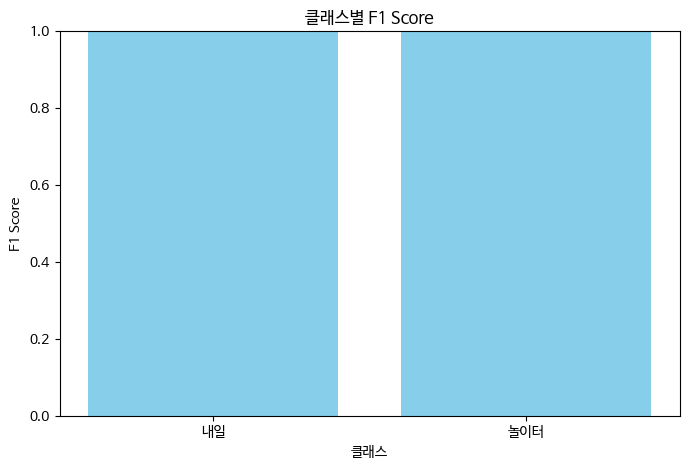

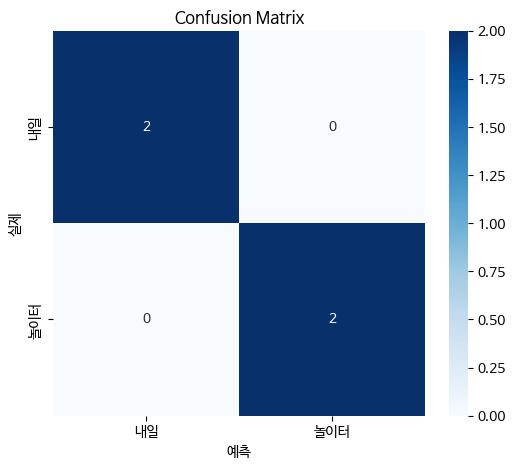

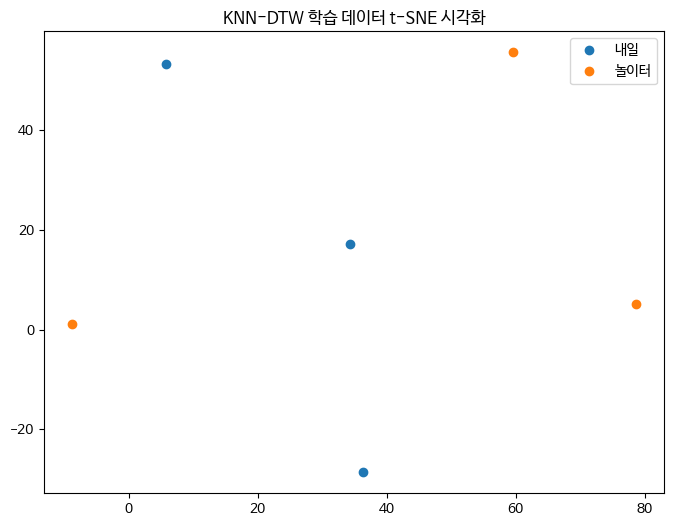

전체 F1 Score: 1.0


In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import os
import numpy as np
import matplotlib.font_manager as fm

# Configure matplotlib to display Korean characters
!apt-get update -qq > /dev/null
!apt-get install fonts-nanum -qq > /dev/null
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False # Correctly display minus signs

# -- 학습용 기준 ---

train_dir = "train" # 학습 영상이 들어 있는 폴더
train_videos = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for file_name in os.listdir(class_path):
        if file_name.endswith(".avi"):
            video_path = os.path.join(class_path, file_name)
            train_videos.append((video_path, class_name))

print("학습용 영상 리스트 생성 완료, 총개수:", len(train_videos))



# --- 새 영상과 실제 라벨 준비 ---
test_dir = "test"
new_videos = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for file_name in os.listdir(class_path):
        if file_name.endswith(".avi"):
            video_path = os.path.join(class_path, file_name)
            new_videos.append((video_path, class_name))

print("테스트용 영상 리스트 생성 완료, 총개수:", len(new_videos))


y_true = []
y_pred = []

# --- 모든 새 영상 예측 반복 ---
for video_path, true_label in new_videos:
    predicted_label, avg_similarity, judgment, top_k = knn_dtw_classify(
        new_video=video_path,
        train_videos=train_videos,
        k=3,
        num_frames=50,
        w_arm=1.0,
        w_hand=1.1,
        w_torso=0.5,
        alpha=6.5,
        similarity_threshold=0.5
    )
    y_true.append(true_label)
    y_pred.append(predicted_label)
    print(f"영상: {video_path} | 실제: {true_label} | 예측: {predicted_label} | 유사도: {avg_similarity:.3f}")

# --- 클래스별 F1 Score 막대그래프 ---
report = classification_report(y_true, y_pred, output_dict=True)
classes = sorted(list(set(y_true) | set(y_pred)))
f1_scores = [report[c]['f1-score'] for c in classes]

plt.figure(figsize=(8,5))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylim(0,1)
plt.xlabel("클래스")
plt.ylabel("F1 Score")
plt.title("클래스별 F1 Score")
plt.show()

# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("예측")
plt.ylabel("실제")
plt.title("Confusion Matrix")
plt.show()

# --- KNN 학습 데이터 t-SNE 시각화 ---
X, y = [], []
for video_path, label in train_videos:
    arm, hand, torso = extract_vector_groups(video_path)
    arm, hand, torso = resample_seq(arm, 50), resample_seq(hand, 50), resample_seq(torso, 50)
    # Ensure all sequences have the same number of features after resampling, pad with zeros if necessary
    max_features = max(arm.shape[1] if arm.shape[0] > 0 else 0,
                       hand.shape[1] if hand.shape[0] > 0 else 0,
                       torso.shape[1] if torso.shape[0] > 0 else 0)
    arm = np.pad(arm, ((0,0),(0,max_features - arm.shape[1] if arm.shape[1] > 0 else 0)), 'constant')
    hand = np.pad(hand, ((0,0),(0,max_features - hand.shape[1] if hand.shape[1] > 0 else 0)), 'constant')
    torso = np.pad(torso, ((0,0),(0,max_features - torso.shape[1] if torso.shape[1] > 0 else 0)), 'constant')

    vec = np.concatenate([arm.flatten(), hand.flatten(), torso.flatten()])
    X.append(vec)
    y.append(label)

X = np.array(X)

if X.shape[0] > 1 and X.shape[0] > 2 * 2: # Ensure enough samples for t-SNE (n_samples > n_components)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, X.shape[0] - 1)) # Set perplexity less than n_samples
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(8,6))
    for label in set(y):
        idx = [i for i, v in enumerate(y) if v==label]
        plt.scatter(X_embedded[idx,0], X_embedded[idx,1], label=label)
    plt.legend()
    plt.title("KNN-DTW 학습 데이터 t-SNE 시각화")
    plt.show()
else:
    print("Skipping t-SNE visualization: Not enough samples.")


# --- 전체 F1 Score ---
f1 = f1_score(y_true, y_pred, average='macro')
print("전체 F1 Score:", f1)